# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for RCM-SG (SeaGuard) it is different than the RCM-4/5/7/9/11 Processing pipeline which was developed by D.Pashinski.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [77]:
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import ecofocipy.io.rcm_parser as rcm_parser #<- instrument specific
import ecofocipy.io.ncCFsave as ncCFsave
import ecofocipy.metaconfig.load_config as load_config
import ecofocipy.math.geotools as geotools
import ecofocipy.plots.TimeSeriesStickPlot as TSSP

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [78]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2020/Moorings/20ck1a/'

In [79]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/rcmsg/1806SG.txt'
instrument = 'RCMSG 1806'
mooring_meta_file = user_data_dir+'logs/20CK-1A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/rcmsg_cf.yaml'
inst_shortname = 'rcmsg'
###############################################################

#init and load data
rcmsg_wop = rcm_parser.rcm_sg()
(rcmsg_wop_data,rcmsg_wop_header) = rcmsg_wop.parse(filename=datafile,datetime_index=True)

In [80]:
rcmsg_wop_header

['Seaguard RCM SW\n',
 'Product number:\t4430\n',
 'Serial number:\t1806\n',
 '\n',
 '\t\tSystem Parameters(0)\t\t\t\tDCS #182(182)\t\t\t\t\t\t\t\t\t\t\t\t\t\tOxygen Optode #629(629)\n',
 'Record\tTime tag (Gmt)\tBattery Voltage(V)\tMemory Used(Bytes)\tLast Interval(ms)\tTime Correction(ms)\tAbs Speed(cm/s)\tDirection(Deg.M)\tNorth(cm/s)\tEast(cm/s)\tHeading(Deg.M)\tTilt X(Deg)\tTilt Y(Deg)\tSP Std(cm/s)\tStrength(dB)\tPing Count\tAbs Tilt(Deg)\tMax Tilt(Deg)\tStd Tilt(Deg)\tTemperature(DegC)\tO2Concentration(uM)\tAirSaturation(%)\tTemperature(Deg.C)\tCalPhase(Deg)\tTCPhase(Deg)\tC1RPh(Deg)\tC2RPh(Deg)\tC1Amp(mV)\tC2Amp(mV)\tRawTemp(mV)\n']

In [81]:
rcmsg_wop_data.sample(5)

,Record,Battery Voltage(V),Memory Used(Bytes),Last Interval(ms),Time Correction(ms),Abs Speed(cm/s),Direction(Deg.M),North(cm/s),East(cm/s),Heading(Deg.M),...,O2Concentration(uM),AirSaturation(%),Temperature(Deg.C),CalPhase(Deg),TCPhase(Deg),C1RPh(Deg),C2RPh(Deg),C1Amp(mV),C2Amp(mV),RawTemp(mV)
date_time,,,,,,,,,,,,,,,,,,,,,
2020-10-26 07:00:00,2459,8.382,9347072,1799994,0.0,39.092,36.785,31.308,23.409,343.519,...,345.987,78.383,1.211,35.756,37.448,45.325,7.876,763.1,906.6,763.6
2021-09-03 15:30:00,17452,6.981,9420800,1799994,0.0,31.850,38.462,24.939,19.811,0.118,...,371.344,86.007,2.014,34.459,36.151,44.005,7.854,709.4,858.2,740.5
2020-10-31 11:00:00,2707,8.370,9363456,1799994,0.0,21.260,56.863,11.622,17.803,350.195,...,377.528,88.850,2.605,33.948,35.640,43.558,7.918,713.1,885.0,723.5
2021-02-01 23:30:00,7196,7.903,9392128,1799995,0.0,12.523,332.562,11.114,-5.770,309.262,...,375.583,78.124,-1.788,36.380,38.072,45.839,7.767,760.5,927.2,847.6
2021-06-23 04:00:00,13973,7.371,9400320,1799994,0.0,20.746,42.926,15.191,14.129,18.909,...,393.818,82.017,-1.746,35.769,37.461,45.206,7.745,745.5,917.7,846.5


## Oxygen and other ancillary sensor adjusments

Oxygen units should be adjusted and salinity corrections as we initiallize oxygen sensors as if in a 0 PSU environment.  Without a cond cell on board, this needs a secondary instrument.  See QC section below

## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

The can be classified into two categories:
+ interpolate: these change the parameter values in accordance with the time edits
    - linear interpolation is most common
    - averaging of data and rebinning/resampling is also common (this needs to have the "time lable" thought out...)
    - decimating is less common but does not impact the max/min values
+ shift: these do not alter the measurements, just the timestamps they are associated with
    - the round function will work well to correct small time errors/drifts **common**
    - dropping extra precision on time (if you want hourly measurements, just remove all minute/second info... could cause large errors if rounding would have been more appropriate)

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean() but it will label the new datapoint per default instructions.  The default is to label it with the left boundary of the bin.
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift (round)
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
        - you may also be able to *shift* using the pandas datetime round function and specifing the desired frequency.
    + I suggest if no change is needed... df.index.round(freq=*'your native sample freq'*)
    
    
***Half Hour Sample - rounded/truncated***

In [82]:
rcmsg_wop_data.index = rcmsg_wop_data.index.round(freq='30T')
rcmsg_wop_data

,Record,Battery Voltage(V),Memory Used(Bytes),Last Interval(ms),Time Correction(ms),Abs Speed(cm/s),Direction(Deg.M),North(cm/s),East(cm/s),Heading(Deg.M),...,O2Concentration(uM),AirSaturation(%),Temperature(Deg.C),CalPhase(Deg),TCPhase(Deg),C1RPh(Deg),C2RPh(Deg),C1Amp(mV),C2Amp(mV),RawTemp(mV)
date_time,,,,,,,,,,,,,,,,,,,,,
2020-09-05 01:30:00,0,8.999,9285632,1799995,0.0,81.772,103.073,-18.496,79.652,206.353,...,346.023,96.227,9.172,31.733,33.425,41.526,8.101,969.7,939.6,527.0
2020-09-05 02:00:00,1,8.993,9289728,1799994,0.0,5.575,291.071,2.004,-5.202,206.253,...,346.120,96.231,9.162,31.735,33.427,41.540,8.113,969.8,939.9,527.3
2020-09-05 02:30:00,2,8.999,9289728,1799995,0.0,18.271,286.579,5.213,-17.511,205.850,...,346.060,96.156,9.137,31.748,33.440,41.548,8.107,970.1,940.4,528.1
2020-09-05 03:00:00,3,9.005,9289728,1799995,0.0,8.472,65.890,3.461,7.733,203.440,...,346.476,96.197,9.104,31.750,33.442,41.548,8.107,970.2,940.9,529.1
2020-09-05 03:30:00,4,8.993,9297920,1799995,0.0,35.959,245.727,-14.782,-32.780,160.466,...,346.839,96.238,9.079,31.749,33.441,41.557,8.115,970.6,941.4,529.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 14:00:00,20713,5.710,9441280,1799995,0.0,14.447,57.962,7.664,12.246,37.548,...,254.791,58.612,1.766,39.241,40.933,48.767,7.834,838.5,860.2,747.7
2021-11-10 14:30:00,20714,5.710,9441280,1799995,0.0,14.441,56.056,8.064,11.980,39.928,...,254.902,58.636,1.765,39.236,40.928,48.764,7.836,838.3,860.3,747.7
2021-11-10 15:00:00,20715,5.717,9441280,1799995,0.0,14.868,54.646,8.603,12.126,41.271,...,252.509,58.084,1.764,39.353,41.045,48.880,7.835,841.3,860.4,747.7


<div class="alert alert-danger">
The 5day added delta is entirely due to a hiccup in raw data processing.  No timedat file was created by the unit so a standin was used.  the standing was off by 5 days.  This can be seen by comparing the tempdata to the deployment time for confirmation.
</div>

In [83]:
rcmsg_wop_data.index = rcmsg_wop_data.index + datetime.timedelta(days=5)

<AxesSubplot: xlabel='date_time'>

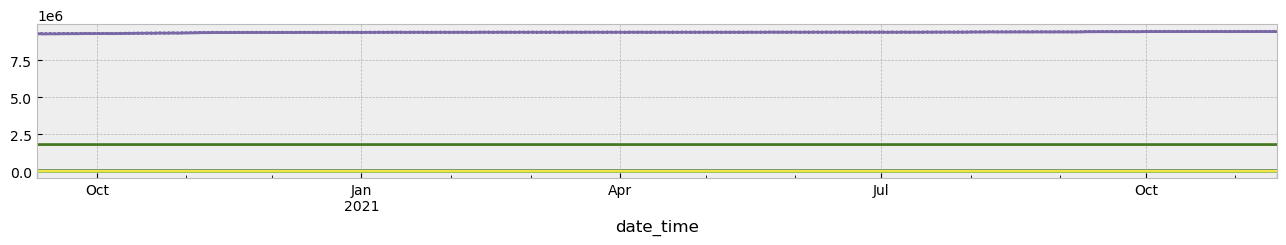

In [84]:
rcmsg_wop_data.plot(figsize=(16,2),legend=False)

## Visual QC of ancillary parameters

We wont keep all the ancillary parameters as they are usually just used for QC of the currents (and are done in the aanderaa software)... we can put them in the preliminary csv file though... anyways, some quick visuals are below to inspire further investigation.

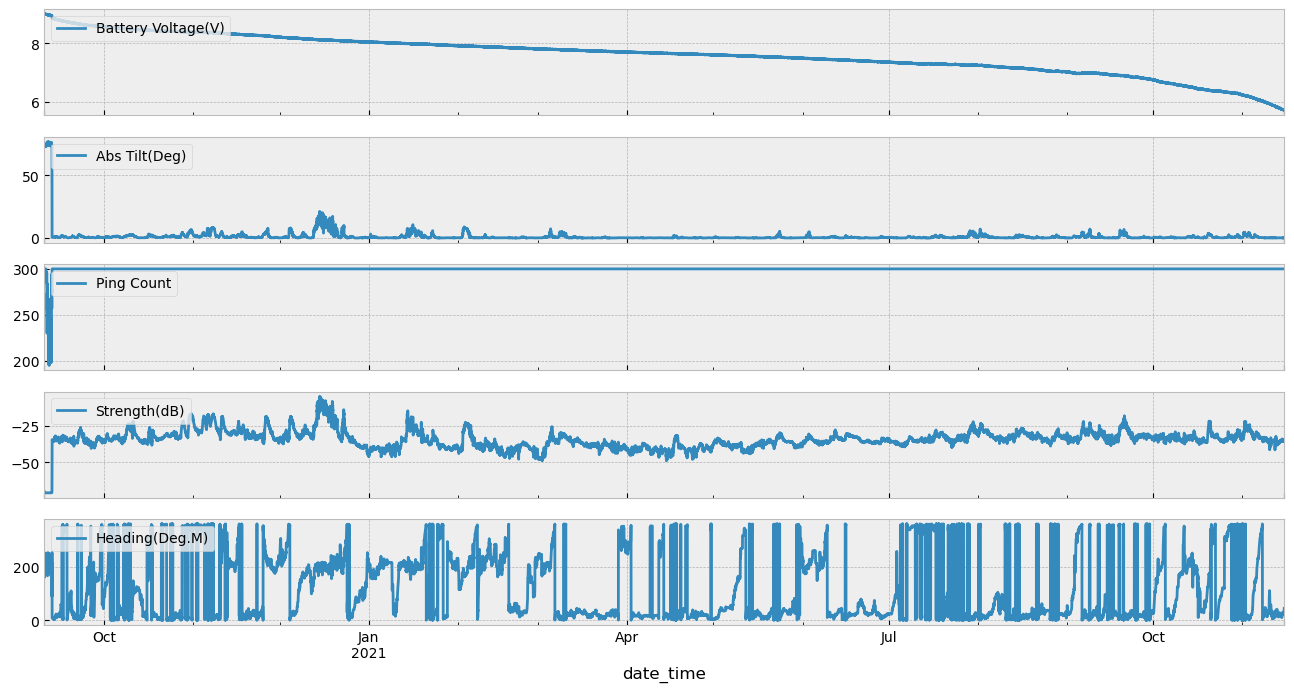

In [85]:
plt_sub = rcmsg_wop_data[['Battery Voltage(V)','Abs Tilt(Deg)','Ping Count','Strength(dB)','Heading(Deg.M)']]

fig, ax = plt.subplots(nrows=len(plt_sub.columns), sharex=True, figsize=(16,8))

for count,parameter in enumerate(plt_sub.columns):
    plt_sub[parameter].plot(ax=ax[count],label=parameter)
    ax[count].legend(loc='upper left')
    

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [86]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [87]:
#some parsing/cleaning for functions
latlon_dec = geotools.latlon_convert(mooring_config['Deployment']['DeploymentLatitude'],
                        mooring_config['Deployment']['DeploymentLongitude'])
dep_date = mooring_config['Deployment']['DeploymentDateTimeGMT'].date()

In [88]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'RCMSG',
 'SerialNo': '1806',
 'DesignedDepth': 41.0,
 'ActualDepth': 41.0,
 'PreDeploymentNotes': '',
 'PostDeploymentNotes': 'no timestamp data, process with a proxy and correct appropriately',
 'Deployed': 'y',
 'Recovered': 'y'}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [89]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)
inst_config

{'time': {'epic_key': 'TIM_601',
  'name': 'time',
  'generic_name': 'time',
  'standard_name': 'time',
  'long_name': 'date and time since reference time'},
 'depth': {'epic_key': 'D_3',
  'generic_name': 'depth',
  'units': 'meter',
  'long_name': 'depth below surface (meters)',
  'standard_name': 'depth',
  'positive': 'down'},
 'latitude': {'epic_key': 'LON_501',
  'name': 'latitude',
  'generic_name': 'latitude',
  'units': 'degrees_north',
  'long_name': 'latitude',
  'standard_name': 'latitude'},
 'longitude': {'epic_key': 'LAT_500',
  'name': 'longitude',
  'generic_name': 'longitude',
  'units': 'degrees_east',
  'long_name': 'longitude',
  'standard_name': 'longitude'},
 'temperature': {'epic_key': 'T_20',
  'generic_name': 'temp',
  'long_name': 'Sea temperature in-situ ITS-90 scale',
  'standard_name': 'sea_water_temperature',
  'units': 'degree_C'},
 'pressure': {'epic_key': 'P_1',
  'generic_name': 'pres',
  'units': 'decibar',
  'long_name': 'Sea water pressure, equals 0

In [90]:
#rcmsg data uses header info to name variables... but we want standard names from the dictionary I've created, so we need to rename column variables appropriately
#rename values to appropriate names, if a value isn't in the .yaml file, you can add it

#TODO: Manage ancillary instrumentation
rcmsg_wop_data = rcmsg_wop_data.rename(columns={'Temperature(DegC)':'temperature',
                        'O2Concentration(uM)':'oxy_concM',
                        'AirSaturation(%)':'oxy_percentsat',
                        'East(cm/s)':'u_curr_comp',
                        'North(cm/s)':'v_curr_comp',
                        'Abs Speed(cm/s)':'current_speed',
                        'Temperature(Deg.C)':'oxy_temperature', #notice the '.' in the units... this seems to identify the oxy temp
                        })

### add a column for oxy_conc
# rcmsg_wop_data.insert(0,'oxy_conc',np.nan)

rcmsg_wop_data.sample()


,Record,Battery Voltage(V),Memory Used(Bytes),Last Interval(ms),Time Correction(ms),current_speed,Direction(Deg.M),v_curr_comp,u_curr_comp,Heading(Deg.M),...,oxy_concM,oxy_percentsat,oxy_temperature,CalPhase(Deg),TCPhase(Deg),C1RPh(Deg),C2RPh(Deg),C1Amp(mV),C2Amp(mV),RawTemp(mV)
date_time,,,,,,,,,,,,,,,,,,,,,
2021-07-13 11:00:00,14707,7.298,9400320,1799995,0.0,15.175,37.286,12.074,9.193,347.803,...,388.552,81.039,-1.696,35.908,37.6,45.346,7.746,748.9,915.8,845.1


## Magnetic Declination Correction

In [91]:
rcmsg_wop.load(rcmsg_wop_data)

dec_corr = rcmsg_wop.mag_dec_corr(latlon_dec[0],latlon_dec[1],dep_date,apply_correction=True)
# dec_corr
#set a declination correction note somewhere in attributes (currently in history)

## Visualization of Mag Dec Corrected Current, Temperture and Oxy (if available) or any other parameter

/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)


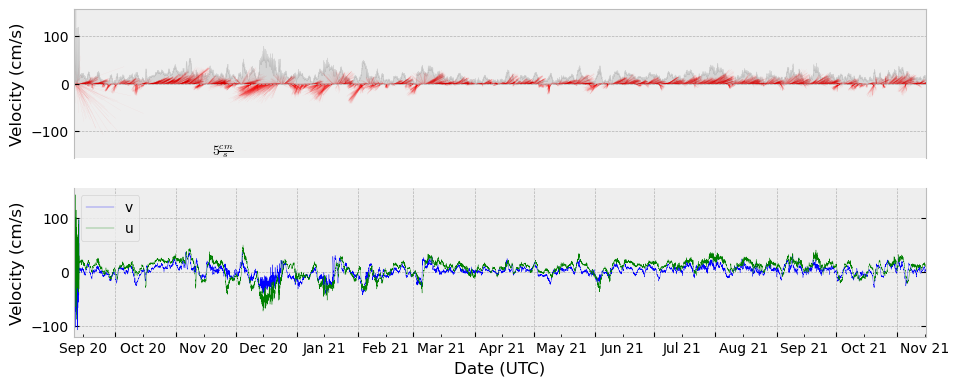

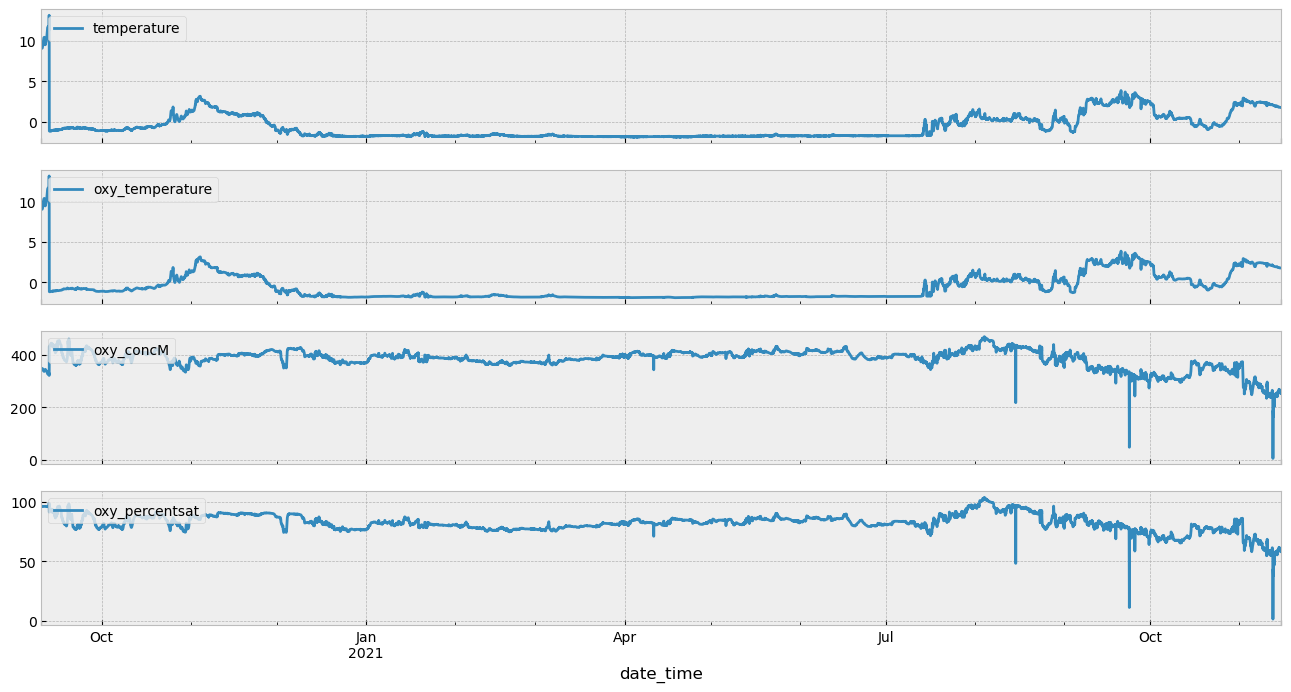

In [115]:
stickplot = TSSP.Timeseries1dStickPlot()
fig,ax = stickplot.plot(rcmsg_wop_data.index,udata=rcmsg_wop_data['u_curr_comp'],vdata=rcmsg_wop_data['v_curr_comp'], rotate=0)

fig, ax = plt.subplots(nrows=len(plt_sub.columns), sharex=True, figsize=(16,8))
plt_sub = rcmsg_wop_data[['temperature','oxy_temperature','oxy_concM','oxy_percentsat']]
for count,parameter in enumerate(plt_sub.columns):
    plt_sub[parameter].plot(ax=ax[count],label=parameter)
    ax[count].legend(loc='upper left')


In [93]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
rcmsg_wop_nc = ncCFsave.EcoFOCI_CFnc(df=rcmsg_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
rcmsg_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [94]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
rcmsg_wop_nc.expand_dimensions()

In [95]:
#build list from columsn in data - if a variable isn't in the yaml file, it will be dropped from the final data fields
rcmsg_wop_nc.variable_meta_data(variable_keys=list(rcmsg_wop_data.columns.values),drop_missing=True)
rcmsg_wop_nc.temporal_geospatioal_meta_data(depth='designed')
#adding dimension meta needs to come after updating the dimension values... BUG?
rcmsg_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [96]:
#add global attributes
rcmsg_wop_nc.deployment_meta_add()
rcmsg_wop_nc.get_xdf()

#add instituitonal global attributes
rcmsg_wop_nc.institution_meta_add()

#add creation date/time - provenance data
rcmsg_wop_nc.provinance_meta_add()

#provide intial qc status field
rcmsg_wop_nc.qc_status(qc_status='unknown')

#declination correction as part of history
rcmsg_wop_nc.history(f'Declination Correction = {dec_corr}')

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [97]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
rcmsg_wop_nc.xarray2netcdf_save(xdf = rcmsg_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

#csvoutput if necessary
(rcmsg_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))

In [98]:
rcmsg_wop_nc.get_xdf()

<xarray.Dataset>
Dimensions:          (time: 20718, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time             (time) datetime64[ns] 2020-09-10T01:30:00 ... 2021-11-15...
  * latitude         (latitude) float64 70.84
  * longitude        (longitude) float64 -163.1
  * depth            (depth) float64 41.0
Data variables:
    current_speed    (time, depth, latitude, longitude) float64 81.77 ... 14.38
    v_curr_comp      (time, depth, latitude, longitude) float64 -31.74 ... 6.047
    u_curr_comp      (time, depth, latitude, longitude) float64 75.36 ... 13.05
    temperature      (time, depth, latitude, longitude) float64 9.208 ... 1.778
    oxy_concM        (time, depth, latitude, longitude) float64 346.0 ... 252.2
    oxy_percentsat   (time, depth, latitude, longitude) float64 96.23 ... 58.0
    oxy_temperature  (time, depth, latitude, longitude) float64 9.172 ... 1.762
Attributes: (12/13)
    Latitude_DegMMddW:                      70 50.16 N
    Longitude_DegMMddN:                     163 07.10 W
    MooringID:                              20CK-1A
    platform_deployment_date:               2020-09-12T18:15:00Z
    platform_deployment_cruise_name:        DY2012
    platform_recovery_date:                 2022-10-16T18:44:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  
    WaterDepth:                             45.0
    date_created:                           2022-11-23T11:02:49Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Declination Correction = (       ...

## Next Steps - These are usually deployment specific

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

### Open Netcdf File

In [99]:
import xarray as xa

rcmsg_df = xa.load_dataset(filename)

### Trimmed Velocity TimeSeries

/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)


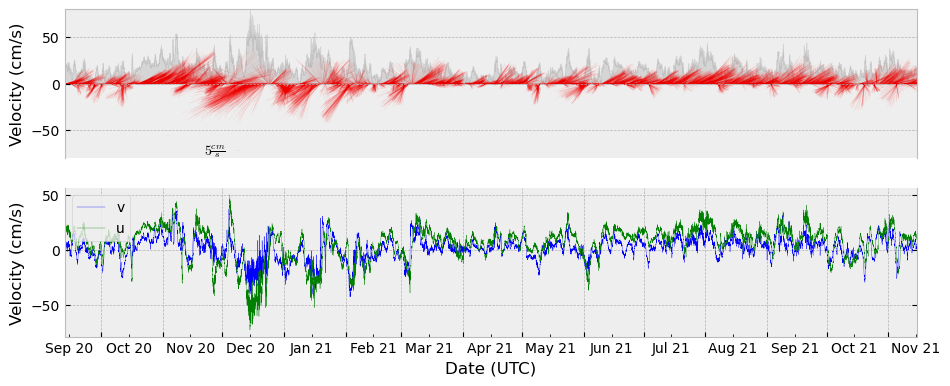

In [100]:
stickplot = TSSP.Timeseries1dStickPlot()
fig,ax = stickplot.plot(rcmsg_df['time'],udata=rcmsg_df['u_curr_comp'][:,0,0,0],vdata=rcmsg_df['v_curr_comp'][:,0,0,0], rotate=0)

### Compare against CTD's

In [101]:
import pandas as pd
import EcoFOCIpy.io.erddap as erddap

url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [102]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='final',concastno='047')
# reccast = erddap.erddapCTDretrieve(url=url,cruiseid='nw2101',qclevel='preliminary',concastno='041')

In [103]:
depcast.columns = [x.split(' ')[0] for x in depcast.columns]
# reccast.columns = [x.split(' ')[0] for x in reccast.columns]

some variable names switch between preliminary and final... this will eventually be resolved

In [104]:
rcmsg_df

<xarray.Dataset>
Dimensions:          (time: 20588, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time             (time) datetime64[ns] 2020-09-12T18:30:00 ... 2021-11-15...
  * latitude         (latitude) float64 70.84
  * longitude        (longitude) float64 -163.1
  * depth            (depth) float64 41.0
Data variables:
    current_speed    (time, depth, latitude, longitude) float64 30.37 ... 14.38
    v_curr_comp      (time, depth, latitude, longitude) float64 -1.596 ... 6.047
    u_curr_comp      (time, depth, latitude, longitude) float64 30.33 ... 13.05
    temperature      (time, depth, latitude, longitude) float64 -1.09 ... 1.778
    oxy_concM        (time, depth, latitude, longitude) float64 431.5 ... 252.2
    oxy_percentsat   (time, depth, latitude, longitude) float64 91.45 ... 58.0
    oxy_temperature  (time, depth, latitude, longitude) float64 -1.144 ... 1.762
Attributes: (12/13)
    Latitude_DegMMddW:                      70 50.16 N
    Longitude_DegMMddN:                     163 07.10 W
    MooringID:                              20CK-1A
    platform_deployment_date:               2020-09-12T18:15:00Z
    platform_deployment_cruise_name:        DY2012
    platform_recovery_date:                 2022-10-16T18:44:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  
    WaterDepth:                             45.0
    date_created:                           2022-11-23T11:02:49Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Declination Correction = (       ...

In [117]:
depcast[depcast['pressure'] == 40]['salinity_ch1']

2898    32.7907
Name: salinity_ch1, dtype: float64

(25.0, 125.0)

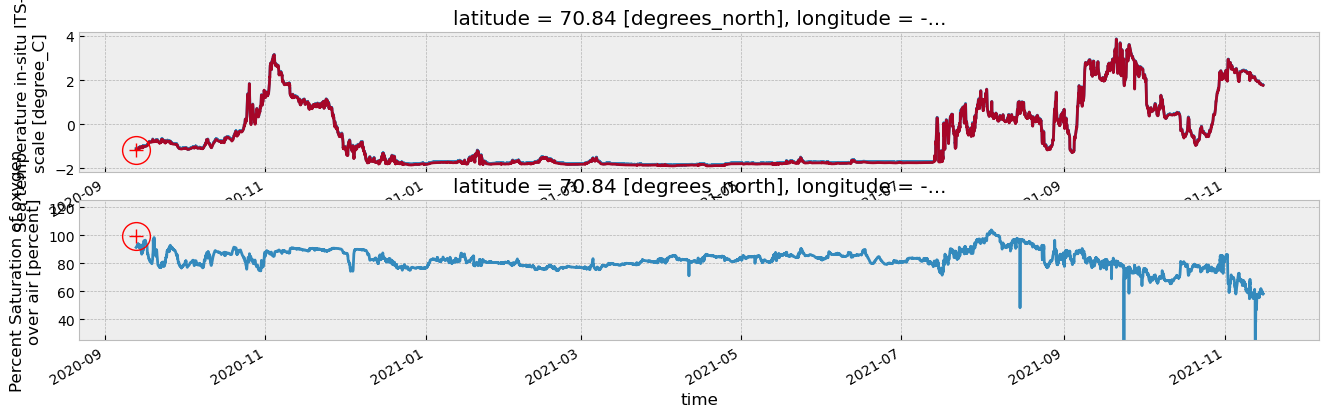

In [106]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(2,figsize=(16, 4))
rcmsg_df.temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
rcmsg_df.oxy_temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
rcmsg_df.oxy_percentsat.plot(x="time",hue="depth",ax=ax[1], add_legend=False);
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['oxy_percentsat_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['oxy_percentsat_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax[1].set_ylim([25,125])

### QC Notes from plots

- ***need to correct oxygen with local salinity***
- trim deploy/recovery better


### Correct Oxygen to local Salinity

In [118]:
import ecofocipy.math.aandopt_oxy_corr as corrO2

In [119]:
rcmsg_df

<xarray.Dataset>
Dimensions:          (time: 20588, latitude: 1, longitude: 1, depth: 1)
Coordinates:
  * time             (time) datetime64[ns] 2020-09-12T18:30:00 ... 2021-11-15...
  * latitude         (latitude) float64 70.84
  * longitude        (longitude) float64 -163.1
  * depth            (depth) float64 41.0
Data variables:
    current_speed    (time, depth, latitude, longitude) float64 30.37 ... 14.38
    v_curr_comp      (time, depth, latitude, longitude) float64 -1.596 ... 6.047
    u_curr_comp      (time, depth, latitude, longitude) float64 30.33 ... 13.05
    temperature      (time, depth, latitude, longitude) float64 -1.09 ... 1.778
    oxy_concM        (time, depth, latitude, longitude) float64 431.5 ... 252.2
    oxy_percentsat   (time, depth, latitude, longitude) float64 91.45 ... 58.0
    oxy_temperature  (time, depth, latitude, longitude) float64 -1.144 ... 1.762
    oxy_conc         (time, longitude, latitude, depth) float64 345.6 ... 203.0
Attributes: (12/13)
    Latitude_DegMMddW:                      70 50.16 N
    Longitude_DegMMddN:                     163 07.10 W
    MooringID:                              20CK-1A
    platform_deployment_date:               2020-09-12T18:15:00Z
    platform_deployment_cruise_name:        DY2012
    platform_recovery_date:                 2022-10-16T18:44:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  
    WaterDepth:                             45.0
    date_created:                           2022-11-23T11:02:49Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Declination Correction = (       ...

In [120]:
#use a constant salinity chosen based on a few CTD casts
const_sal = (rcmsg_df.temperature.isel({'latitude':0,'longitude':0,'depth':0}) * 0) +32.791

In [121]:
temp = corrO2.o2_dep_comp(oxygen_conc=rcmsg_df.oxy_concM, depth=rcmsg_df.depth)
oxy_conc = corrO2.o2_sal_comp(temp.isel({'latitude':0,'longitude':0,'depth':0}), salinity=const_sal, temperature=rcmsg_df.temperature.isel({'latitude':0,'longitude':0,'depth':0}))

In [122]:
rcmsg_df['oxy_conc'] = rcmsg_df.oxy_concM * 0
rcmsg_df['oxy_conc'] = oxy_conc
rcmsg_df['oxy_conc'] = rcmsg_df.oxy_conc.expand_dims({'depth':1,'latitude':1,'longitude':1}).T
 #<-- this needs to go to the netcdf file.
rcmsg_df.attrs.update({'history':rcmsg_df.history + '\nOxygen Salinity Corrected'})

rcmsg_df.drop('oxy_concM').to_netcdf(filename,format='NETCDF3_CLASSIC',encoding={'time':{'units':'days since 1900-01-01'}})

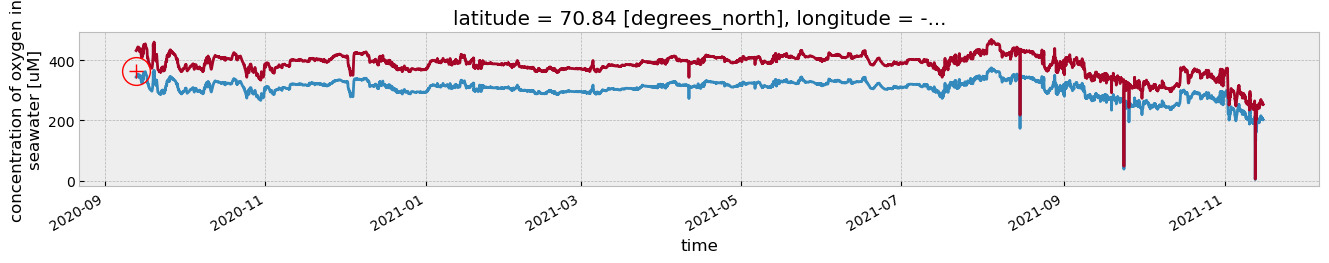

In [123]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
# depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
rcmsg_df.oxy_conc.plot(x="time",hue="depth",ax=ax, add_legend=False);
rcmsg_df.oxy_concM.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['oxy_conc_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['oxy_conc_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['O_65'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['O_65'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

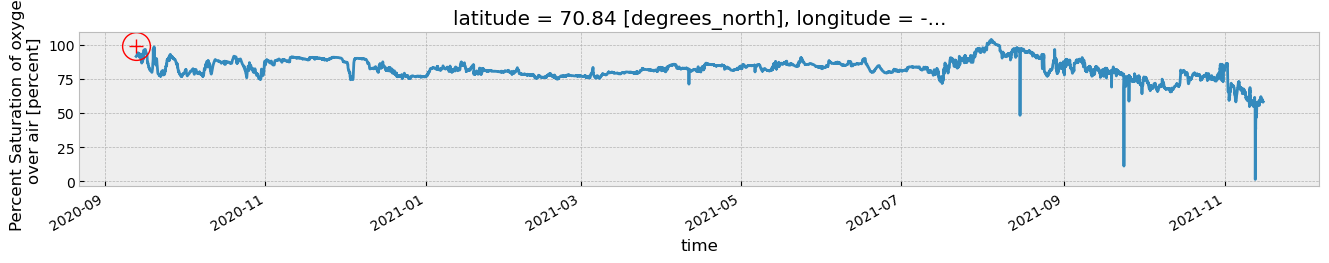

In [124]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
rcmsg_df.oxy_percentsat.plot(x="time",hue="depth",ax=ax, add_legend=False);
# rcmsg_df.oxy_concM.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['oxy_percentsat_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['oxy_percentsat_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['oxy_percentsat_ch1'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['oxy_percentsat_ch1'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray


In [127]:
import xarray as xr
import datetime

rcmsg_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','to_edit.csv'), index_col=['time','latitude','longitude','depth']) #order is important

In [128]:
rcmsg_df

<xarray.Dataset>
Dimensions:          (time: 20588, latitude: 1, longitude: 1, depth: 1)
Coordinates:
  * time             (time) datetime64[ns] 2020-09-12T18:30:00 ... 2021-11-15...
  * latitude         (latitude) float64 70.84
  * longitude        (longitude) float64 -163.1
  * depth            (depth) float64 41.0
Data variables:
    current_speed    (time, depth, latitude, longitude) float64 30.37 ... 14.38
    v_curr_comp      (time, depth, latitude, longitude) float64 -1.596 ... 6.047
    u_curr_comp      (time, depth, latitude, longitude) float64 30.33 ... 13.05
    temperature      (time, depth, latitude, longitude) float64 -1.09 ... 1.778
    oxy_concM        (time, depth, latitude, longitude) float64 431.5 ... 252.2
    oxy_percentsat   (time, depth, latitude, longitude) float64 91.45 ... 58.0
    oxy_temperature  (time, depth, latitude, longitude) float64 -1.144 ... 1.762
    oxy_conc         (time, longitude, latitude, depth) float64 343.7 ... 201.9
Attributes: (12/13)
    Latitude_DegMMddW:                      70 50.16 N
    Longitude_DegMMddN:                     163 07.10 W
    MooringID:                              20CK-1A
    platform_deployment_date:               2020-09-12T18:15:00Z
    platform_deployment_cruise_name:        DY2012
    platform_recovery_date:                 2022-10-16T18:44:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  
    WaterDepth:                             45.0
    date_created:                           2022-11-23T11:02:49Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Declination Correction = (       ...

In [129]:
rcmsg_df['oxy_percentsat'].values = xr.Dataset.from_dataframe(rcmsg_df_qc)['oxy_percentsat']
rcmsg_df['oxy_conc'].values = xr.Dataset.from_dataframe(rcmsg_df_qc)['oxy_conc']
# rcmsg_df['oxy_temperature'].values = xr.Dataset.from_dataframe(rcmsg_df_qc)['oxy_temperature']

In [130]:
rcmsg_df.attrs.update({'QC_indicator': 'ProbablyGood'})
rcmsg_df.attrs.update({'history':(rcmsg_df.history + "\nQC'd: "+ str(datetime.datetime.today()))})


In [131]:
rcmsg_df.attrs.update({'date_modified':str(datetime.datetime.today())})

In [132]:
rcmsg_df.drop('oxy_concM').to_netcdf(filename,format='NETCDF3_CLASSIC',encoding={'time':{'units':'days since 1900-01-01'}})